# MET 421 Final Case Study Figures
### by Wyatt Ficek

First, import necessary packages

In [1]:
# matplotlib import
import matplotlib.pyplot as plt 

# NumPy import
import numpy as np

# MetPy imports
import metpy.calc as mpcalc
from metpy.plots import SkewT
from metpy.units import units
from metpy.plots import MapPanel, PanelContainer, PlotGeometry

# Pandas and Geopandas imports
import pandas as pd
import geopandas as gpd

# Cartopy imports
import cartopy.crs as ccrs
import cartopy.feature as cfeature 

Figure 1: Skew-T Diagram of the KDVN 3/31/2023 18Z Special Sounding

Text(0.5, 1.0, 'KDVN (Davenport, IA) 31 March 2023 1800Z Special Sounding by Wyatt Ficek')

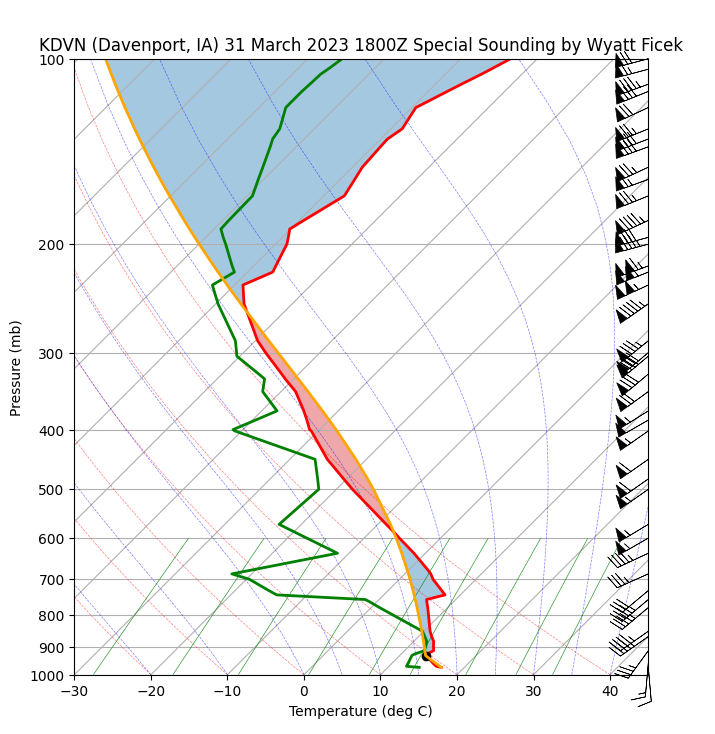

In [2]:
# List of column labels for variables
col_names = ['pressure', 'height', 'temperature', 'dewpoint', 'direction', 'speed']

# Read in text file of sounding data from U Wyoming page and create dataframe
sounding_dataframe = pd.read_fwf('dvn_sounding.txt', skiprows=5, usecols=[0, 1, 2, 3, 6, 7], names=col_names)

# Obtain U and V wind components via speed and direction values
u, v = mpcalc.wind_components(sounding_dataframe['speed'].values * units.knot, sounding_dataframe['direction'].values * units.degree)
sounding_dataframe['u_wind'] = u.magnitude
sounding_dataframe['v_wind'] = v.magnitude

# Remove rows with missing data
sounding_dataframe = sounding_dataframe.dropna(subset=('temperature', 'dewpoint', 'direction', 'speed','u_wind', 'v_wind'), how='all').reset_index(drop=True)

# Assign data columns to a variable and add units
p = sounding_dataframe['pressure'].values * units.hPa
T = sounding_dataframe['temperature'].values * units.degC
Td = sounding_dataframe['dewpoint'].values * units.degC # Type your code here and run the cell to provide the answer
u = sounding_dataframe['u_wind'].values * units.knots
v = sounding_dataframe['v_wind'].values * units.knots

# Create SkewT figure canvas
fig = plt.figure(figsize=(8, 8))
skew = SkewT(fig, rotation=45)

# Plot data
skew.plot(p, T, 'r',linewidth=2)
skew.plot(p, Td, 'g',linewidth=2)
interval = np.logspace(2,3) * units.hPa # Create a re-sample array to 'thin' out the data for plotting wind barbs.
idx=mpcalc.resample_nn_1d(p,interval)

# Set limits for axes
skew.ax.set_ylim(1000, 100)
skew.ax.set_xlim(-30, 45)

# Plot wind barbs
skew.plot_barbs(p[idx], u[idx], v[idx],linewidth=0.5)

# Calculate and plot LCL pressure and temp
lcl_pressure, lcl_temperature = mpcalc.lcl(p[0], T[0], Td[0])
skew.plot(lcl_pressure, lcl_temperature, 'ko', markerfacecolor='black')

# Calculate parcel profile and plot as orange line
prof = mpcalc.parcel_profile(p, T[0], Td[0]).to('degC') # Calculate the parcel profile and store it to variable 'prof'
skew.plot(p, prof, 'orange', linewidth=2) # plot the 'prof' on the skew-T plot as an orange line with a width of 2 pixels

# Shade in CAPE
skew.shade_cape(p, T, prof)

# Shade in CINH
skew.shade_cin(p, T, prof) # Type your code here and run the cell to provide the answer

# Add the relevant special lines
skew.plot_dry_adiabats(color='brown', linewidth=0.5)
skew.plot_moist_adiabats(color='darkgreen', linewidth=0.5)
skew.plot_mixing_lines(color='limegreen', linewidth=0.5, linestyle='-')

# Label the axes
skew.ax.set_ylabel('Pressure (mb)')
skew.ax.set_xlabel('Temperature (deg C)')

# Title the figure
plt.title('KDVN (Davenport, IA) 31 March 2023 1800Z Special Sounding by Wyatt Ficek')

Figure 2: Tornado, Hail, and Damaging Wind Reports for 3/31/23 and 4/1/23

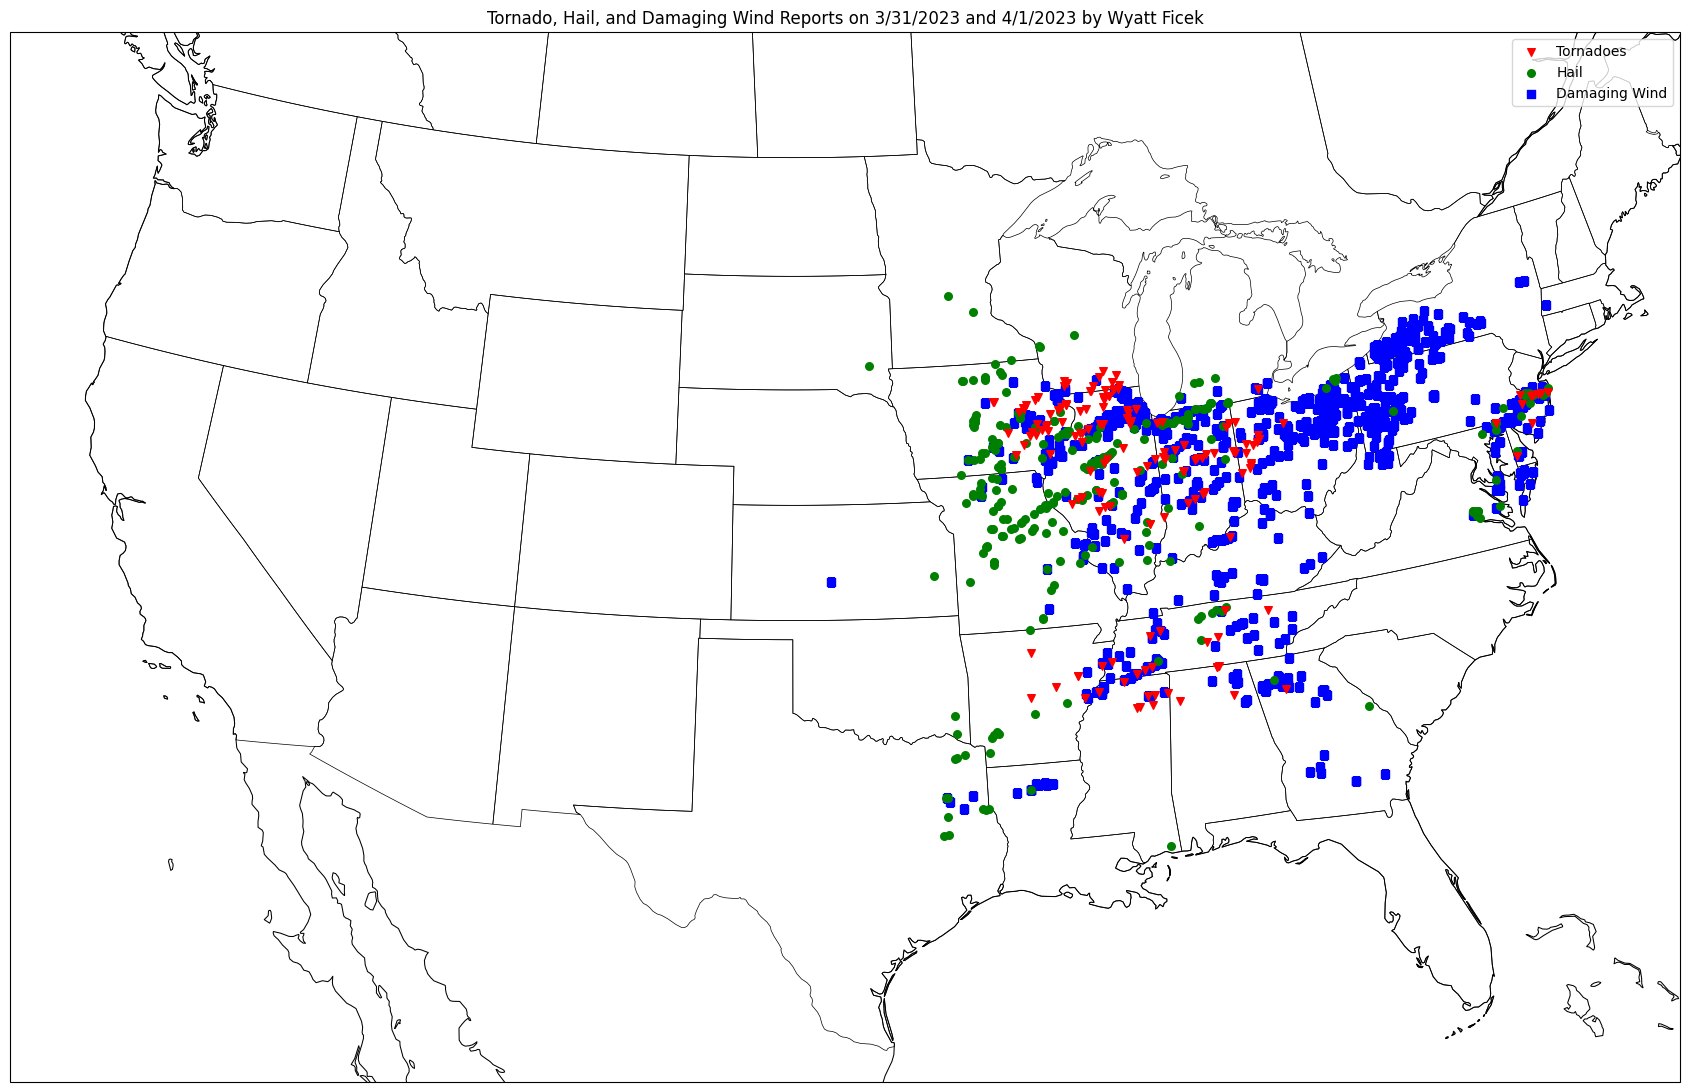

In [3]:
# Read in CSV files
tor = pd.read_csv("2023_torn.csv")
hail = pd.read_csv("2023_hail.csv")
wind = pd.read_csv("2023_wind.csv")

# Function to concat data to the days of interest
def concat_to_event(data):
    data_03312023 = data[data.date == "2023-03-31"]
    data_04012023 = data[data.date == "2023-04-01"]

    return pd.concat([data_03312023, data_04012023], axis = 0)

# Run the CSVs through the function
tor_event = concat_to_event(tor)
hail_event = concat_to_event(hail)
wind_event = concat_to_event(wind)


# Set up the projection
crs = ccrs.LambertConformal(central_longitude=-100.0, central_latitude=45.0)

# Coordinates to limit map area
bounds = [(-122., -75., 25., 50.)]

# Store state and province boundaries as a variable to be passed later
states_provinces = cfeature.NaturalEarthFeature(category='cultural',name='admin_1_states_provinces_lakes',scale='50m',facecolor='none')

# Create a canvas and add geography
fig = plt.figure(figsize=(17., 12.))
ax = fig.add_subplot(1, 1, 1, projection=crs)
ax.set_extent(*bounds, crs=ccrs.PlateCarree())
ax.coastlines('50m', edgecolor='black', linewidth=0.75)
ax.add_feature(states_provinces, edgecolor='black', linewidth=0.5)

# Plot tornado starting points
ax.scatter(tor_event['slon'], tor_event['slat'], marker='v', color='red', s=30, transform=ccrs.PlateCarree(), label='Tornadoes', zorder=5)
ax.scatter(hail_event['slon'], hail_event['slat'], marker='o', color='green', s=30, transform=ccrs.PlateCarree(), label='Hail', zorder=4)
ax.scatter(wind_event['slon'], wind_event['slat'], marker='s', color='blue', s=30, transform=ccrs.PlateCarree(), label='Damaging Wind', zorder=3)

# Add legend
plt.legend()

# Titles the figure
plt.title("Tornado, Hail, and Damaging Wind Reports on 3/31/2023 and 4/1/2023 by Wyatt Ficek")

# Create tight layout
plt.tight_layout()

Figure 3: SPC Day 1 Convective Outlook 3/31/23 1630Z Update

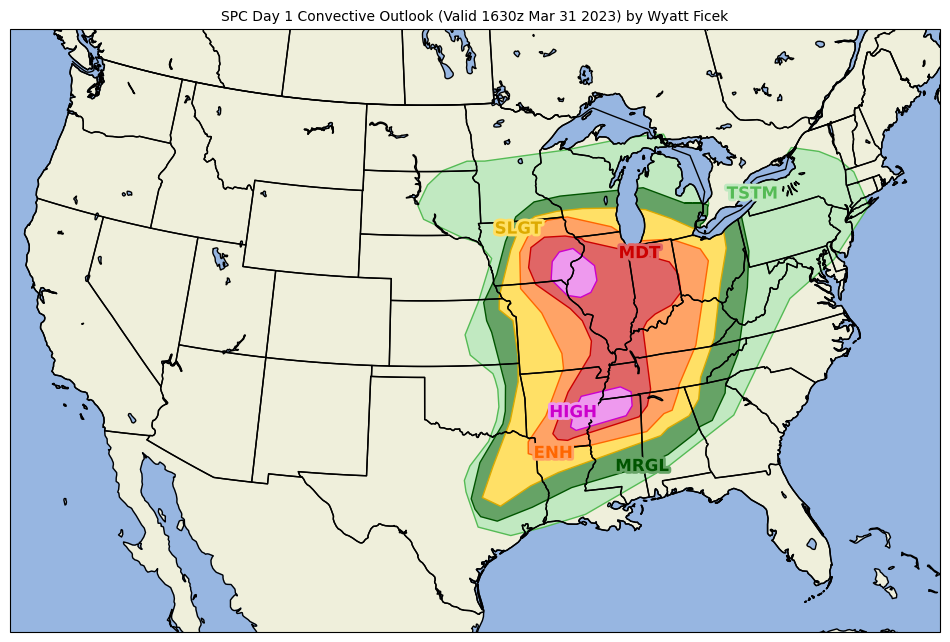

In [4]:
# Read in GeoJSON file from SPC
day1_outlook = gpd.read_file('day1otlk_20230331_1630_cat.lyr.geojson')

# Plots geometry from GeoJSON file
geo = PlotGeometry()
geo.geometry = day1_outlook['geometry']
geo.fill = day1_outlook['fill']
geo.stroke = day1_outlook['stroke']
geo.labels = day1_outlook['LABEL']
geo.label_fontsize = 'large'

# Creates a map panel
panel = MapPanel()
panel.title = 'SPC Day 1 Convective Outlook (Valid 1630z Mar 31 2023) by Wyatt Ficek'
panel.plots = [geo]
panel.area = [-120, -75, 25, 50]
panel.projection = 'lcc'
panel.layers = ['lakes', 'land', 'ocean', 'states', 'coastline', 'borders']

# Creates container for the map panel
pc = PanelContainer()
pc.size = (12, 8)
pc.panels = [panel]
pc.show()

Figure 4: Tornado Paths for 3/31/23 and 4/1/23

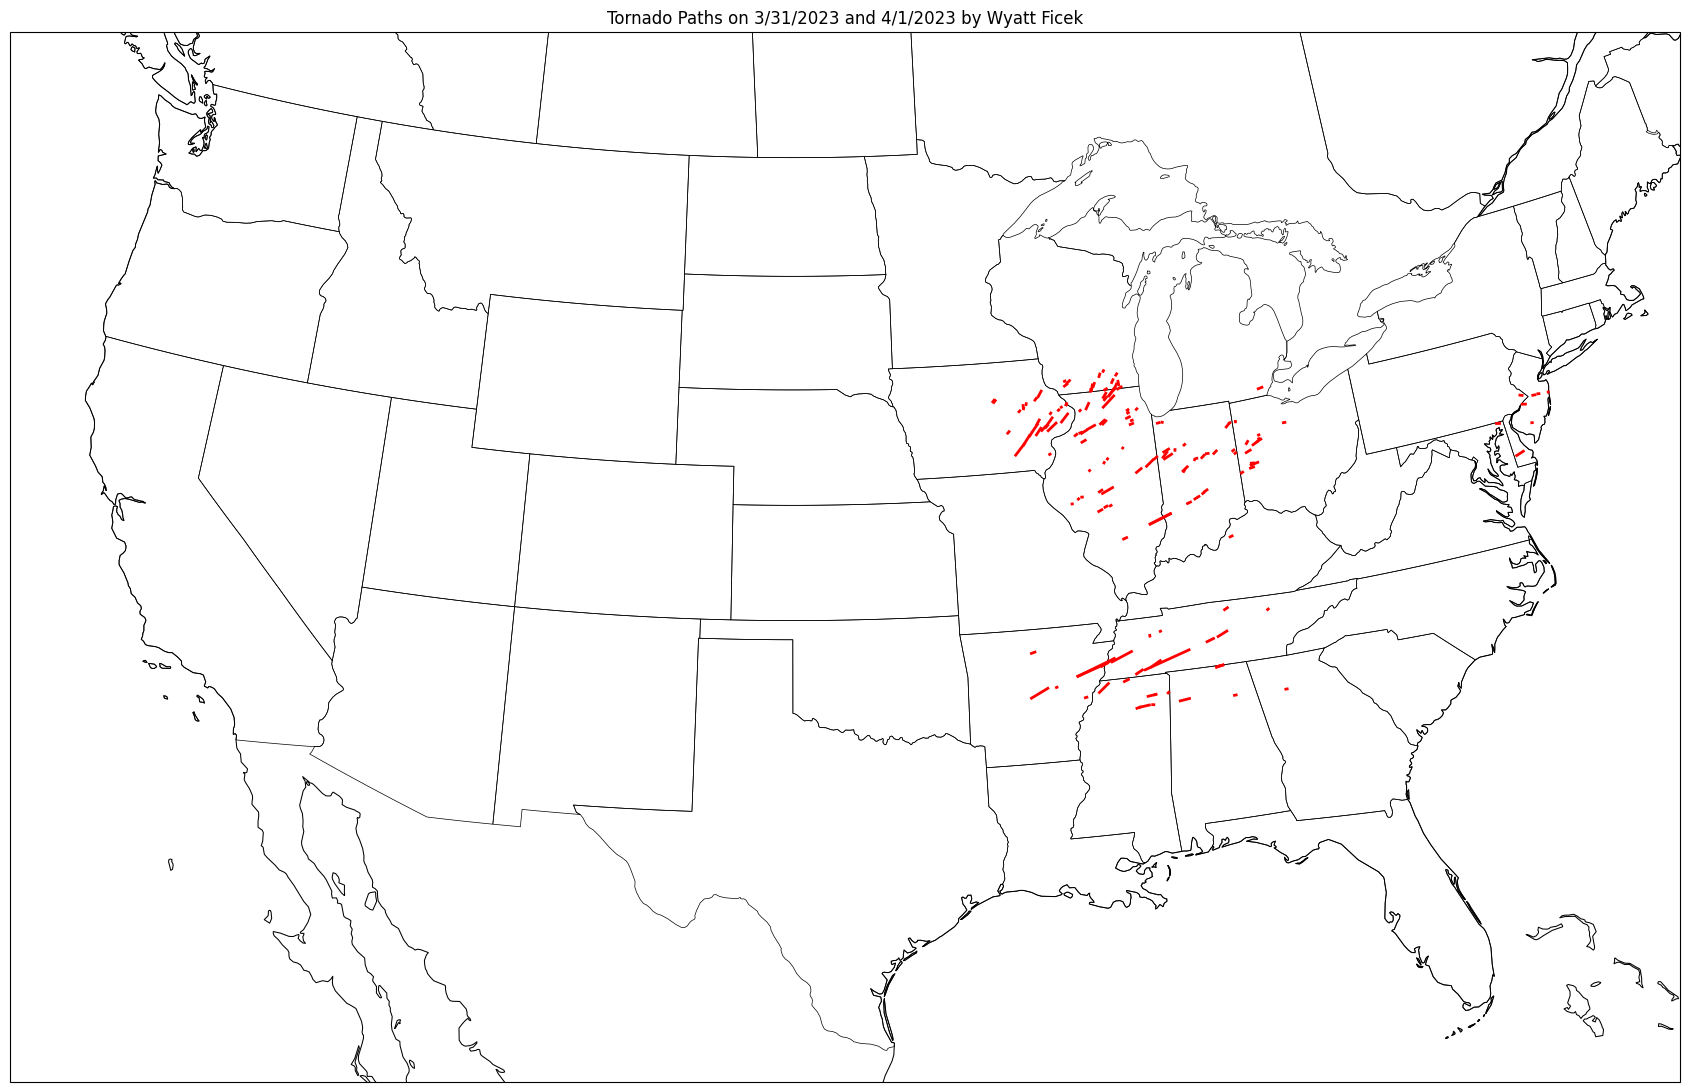

In [5]:
# Set up the projection
crs = ccrs.LambertConformal(central_longitude=-100.0, central_latitude=45.0)

# Coordinates to limit map area
bounds = [(-122., -75., 25., 50.)]

# Store state and province boundaries as a variable to be passed later
states_provinces = cfeature.NaturalEarthFeature(category='cultural',name='admin_1_states_provinces_lakes',scale='50m',facecolor='none')

# Create a canvas and add geography
fig = plt.figure(figsize=(17., 12.))
ax = fig.add_subplot(1, 1, 1, projection=crs)
ax.set_extent(*bounds, crs=ccrs.PlateCarree())
ax.coastlines('50m', edgecolor='black', linewidth=0.75)
ax.add_feature(states_provinces, edgecolor='black', linewidth=0.5)

# Plot tornado path via starting and ending latitudes and longitudes
ax.plot([tor_event['slon'], tor_event['elon']], [tor_event['slat'], tor_event['elat']], color='red', linewidth=2, transform=ccrs.PlateCarree())

# Titles the figure
plt.title("Tornado Paths on 3/31/2023 and 4/1/2023 by Wyatt Ficek")

# Create tight layout
plt.tight_layout()